In [1]:
import os
import pickle
import numpy as np
from scipy.stats import describe
import matplotlib.pyplot as plt
from tqdm import tqdm

import seaborn as sns

sns.set(context="talk", style="ticks", color_codes=True)

from lvmdrp.core import image
from lvmdrp.functions import imageMethod
from lvmdrp.utils import database
from lvmdrp.utils import bitmask

from lvmdrp.main import load_master_config

In [2]:
config = load_master_config()

db = database.create_or_connect_db(config)

raw_flats = database.LVMFrames.select().where(
    (database.LVMFrames.imagetyp == "flat") &
    (database.LVMFrames.status == bitmask.ReductionStatus["RAW"]) &
    (database.LVMFrames.flags == bitmask.QualityFlag["OK"])
).order_by(database.LVMFrames.exptime.asc())

In [48]:
# for each flat frame
    # 	read raw frame
    #   remove overscan regions
    # 	split into amplifiers
    # 	for each amplifier
    #	 	calculate statistics (mean, variance, median, kurt, skew)
    # 		decide which frames/amplifiers go into gain calculation based in skew and kurt
    # plot sigma_counts vs sqrt(mean_counts)
    # fit slope

N_FLATS = raw_flats.count()

flats_list = []

cache_path = "_data-lvm/gain-amps.pk"
if False:
    fmin, fmax, mean, sdev, kurt, skew = pickle.load(open(cache_path, "rb"))
else:
    mean, sdev = {amp: np.zeros(N_FLATS) for amp in "abcd"}, {amp: np.zeros(N_FLATS) for amp in "abcd"}
    skew, kurt = {amp: np.zeros(N_FLATS) for amp in "abcd"}, {amp: np.zeros(N_FLATS) for amp in "abcd"}
    fmin, fmax = {amp: np.zeros(N_FLATS) for amp in "abcd"}, {amp: np.zeros(N_FLATS) for amp in "abcd"}
    exptimes = np.zeros(N_FLATS)
    for j, raw_flat in tqdm(enumerate(raw_flats), total=N_FLATS, desc="fetching raw flats", unit="frame", ascii=True):

        flat = image.loadImage(raw_flat.path)

        # skip flats with fibers
        cut = flat.getSlice(3600, axis='y')
        peaks = cut.findPeaks(threshold=np.median(cut._data), npeaks=41)
        if len(peaks) == 41:
            # print(len(peaks), raw_flat.path)
            continue
    
        flats_list.append(raw_flat.path)

        cd, ab = flat.split(2, axis="Y")
        (a, b), (c, d) = ab.split(2, axis="X"), cd.split(2, axis="X")
        # reflect b and d amplifiers to have the overscan regions in the last columns
        b.orientImage("X")
        d.orientImage("X")
        amps = [a, b, c, d]
        ny, nx = a._data.shape
        for i, (amp_name, amp) in enumerate(zip(mean.keys(), amps)):
            amps[i].cutOverscan(("1","2040"), ("1","2040"), subtract=True)
            # return original X axis orientation
            if i in [1,3]: amps[i].orientImage("X")

            # MASK POTENTIALLY BAD PIXELS
            # mask out pixels affected by vigneting and other border pixels (stay near the center of the CCD)
            # if i in [0,1]:
            #     data_cut = amps[i]._data[ny//10:ny-ny//(100//40), nx//10:nx-nx//10]
            # elif i in [2,3]:
            #     data_cut = amps[i]._data[ny-ny//(100//40):ny-ny//10, nx//10:nx-nx//10]
            # USE WHOLE FRAME
            data_cut = amps[i]._data

            stats = describe(data_cut, axis=None)
            mean[amp_name][j] = stats.mean
            sdev[amp_name][j] = np.sqrt(stats.variance)
            kurt[amp_name][j] = stats.kurtosis
            skew[amp_name][j] = stats.skewness
            fmin[amp_name][j], fmax[amp_name][j] = stats.minmax
    
        # if j == 1:
        #     break
    pickle.dump((fmin, fmax, mean, sdev, kurt, skew), open(cache_path, "wb"))


fetching raw flats: 100%|##########| 1200/1200 [13:57<00:00,  1.43frame/s]


In [51]:
len(flats_list), np.random.choice(flats_list, 10, replace=False)

(1200,
 array(['/home/mejia/Research/UNAM/lvm-drp/data.sdss5.org/sas/sdsswork/data/lvm/lab/59636/sdR-s-r1-00001838.fits.gz',
        '/home/mejia/Research/UNAM/lvm-drp/data.sdss5.org/sas/sdsswork/data/lvm/lab/59535/sdR-s-z1-00001231.fits.gz',
        '/home/mejia/Research/UNAM/lvm-drp/data.sdss5.org/sas/sdsswork/data/lvm/lab/59628/sdR-s-b1-00001781.fits.gz',
        '/home/mejia/Research/UNAM/lvm-drp/data.sdss5.org/sas/sdsswork/data/lvm/lab/59631/sdR-s-r1-00001810.fits.gz',
        '/home/mejia/Research/UNAM/lvm-drp/data.sdss5.org/sas/sdsswork/data/lvm/lab/59538/sdR-s-b1-00001266.fits.gz',
        '/home/mejia/Research/UNAM/lvm-drp/data.sdss5.org/sas/sdsswork/data/lvm/lab/59530/sdR-s-z1-00001097.fits.gz',
        '/home/mejia/Research/UNAM/lvm-drp/data.sdss5.org/sas/sdsswork/data/lvm/lab/59559/sdR-s-b1-00001564.fits.gz',
        '/home/mejia/Research/UNAM/lvm-drp/data.sdss5.org/sas/sdsswork/data/lvm/lab/59559/sdR-s-z1-00001554.fits.gz',
        '/home/mejia/Research/UNAM/lvm-drp/data.s

number of frames: 1200


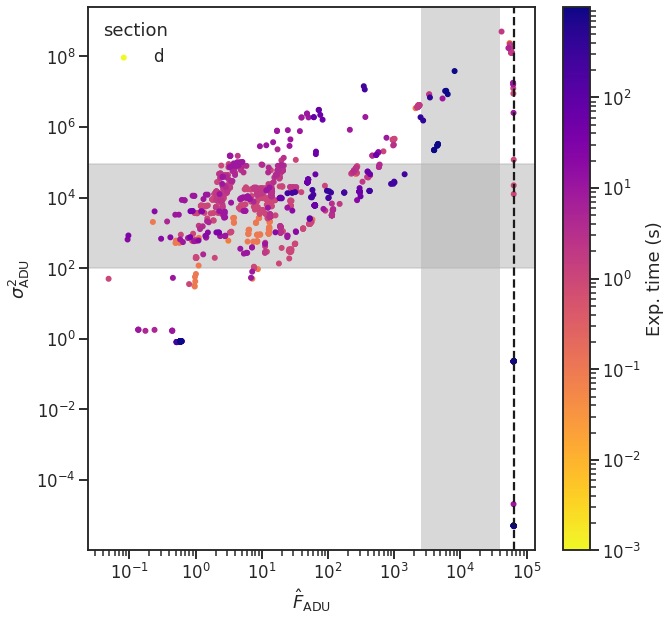

In [50]:
from scipy.optimize import least_squares
import matplotlib as mpl


def model(par, x):
    m, b = par
    return m*x + b

def residuals(par, x, y):
    y_mod = model(par, x)
    return y_mod - y

exptimes = np.asarray([raw_flat.exptime for raw_flat in raw_flats])
mjd = np.asarray([raw_flat.mjd for raw_flat in raw_flats])
# exptimes /= exptimes.max()

fig, ax = plt.subplots(figsize=(10,10))
ax.set_xscale("log")
ax.set_yscale("log")

for amp in "d":
    x, y = mean[amp], sdev[amp]**2
    z = exptimes
    mask = np.ones_like(z, dtype=bool)
    # mask &= (x>=2500)&(x<=40000)
    # mask &= x<=600
    # mask &= np.abs(skew[amp])<=0.5
    # mask &= (y>=10**2)&(y<=300**2)
    # mask &= (z>5)&(z<=100)
    print(f"number of frames: {mask.sum()}")
    if mask.sum() == 0:
        continue
    x, y, z = x[mask], y[mask], z[mask]
    res = least_squares(fun=residuals, x0=(1,0), args=(x, y))

    ax.axvline(2**16, ls="--", color="k")
    ax.axvspan(2500, 40000, color="0.7", alpha=0.5, lw=0)
    ax.axhspan(10**2, 300**2, color="0.7", alpha=0.5)

    xs = np.linspace(x.min(), x.max(), 100)
    ys = model(res.x, xs)
    sc = ax.scatter(x, y, c=z, s=20, label=amp, cmap="plasma_r", norm=mpl.colors.LogNorm())
    cb = plt.colorbar(sc)
    # ax.loglog(xs, ys, "-b")
    # ax.text(0.05, 0.5, f"$\sigma_\mathrm{{ADU}}^2 = {res.x[0]:.2f} \\times \hat{{F}}_\mathrm{{ADU}} {'+' if res.x[1]>=0 else '-'} {np.abs(res.x[1]):.0f}$", size="x-small", transform=ax.transAxes)
    # print(f"gain = {1/res.x[0]}")

    ax.legend(title="section", ncol=2, frameon=False, loc=2)
    ax.set_ylabel(r"$\sigma_\mathrm{ADU}^2$")
    ax.set_xlabel(r"${\hat{F}_\mathrm{ADU}}$")
    cb.set_label("Exp. time (s)")
    fig.savefig(f"gain-amp_{amp}.png", bbox_inches="tight")
